## Scrape Poll in 2012, 2016, 2020, 2024 from Wiki

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import re



In [3]:
def get_soup(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def find_table_in_html(soup, tags: list):
    ##so far apply to both 2012& 2016& 2020
    ##suppose they are the same shape in same year
    table = []
    for tag in tags:
        span_tag = soup.find('span', {'id': tag})
        table_after_span = span_tag.find_next('table')
        
        for row in table_after_span.find_all('tr'):
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            if cols:
                table.append(cols)
    return table
    

## 2024 Poll

In [4]:
## Hand Scrape From Wiki bc its html is too messy (for me)
Poll_2024 = pd.read_csv("Taiwan Presidental Election - Three Way Race Poll 2024.csv")
Poll_2024 = Poll_2024[["Pollster","Poll Last Day","Lai-Hsiao DPP","Hou-Jaw KNIT","Ko-Wu TPP"]]
Poll_2024.dropna(inplace=True)
Poll_2024.rename(columns={"Pollster": "Source","Poll Last Day":"Poll Date","Lai-Hsiao DPP":"Green","Hou-Jaw KNIT":"Blue","Ko-Wu TPP":"Third"},inplace=True)
Poll_2024[["Blue","Green","Third"]] = Poll_2024[["Blue","Green","Third"]].applymap(lambda x: pd.to_numeric(str(x).replace('%', ''), errors='coerce'))
Poll_2024['Poll Date'] = pd.to_datetime(Poll_2024['Poll Date'], format="%d-%b-%y")
Poll_2024['Election Year'] = 2024
Poll_2024['Election Date'] = '2024-01-13'

Poll_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, 0 to 66
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Source         67 non-null     object        
 1   Poll Date      67 non-null     datetime64[ns]
 2   Green          67 non-null     float64       
 3   Blue           67 non-null     float64       
 4   Third          64 non-null     float64       
 5   Election Year  67 non-null     int64         
 6   Election Date  67 non-null     object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 4.2+ KB


## 2020 Poll

In [5]:
# URL of the Wikipedia page
url_2020= 'https://en.wikipedia.org/wiki/Opinion_polling_for_the_2020_Taiwanese_general_election'

# tag to find 
tag_2020_soong =["Polls_with_candidates"] 
tag_2020_ko =["Polls_with_previous_potential_candidates"] 

# Get table
table_2020_soong_raw = find_table_in_html(get_soup(url_2020),tag_2020_soong)
table_2020_ko_raw = find_table_in_html(get_soup(url_2020),tag_2020_ko)

# Put into DataFrame & shape
Poll_2020_soong = pd.DataFrame(table_2020_soong_raw, columns=["Poll Date","Source","Sample_Size","Blue","Third:Soong","Green"])
Poll_2020_ko = pd.DataFrame(table_2020_ko_raw, columns=["Poll Date","Source","Sample_Size","Third:Ko","Blue","Green"])

# Clean seperatly incase seperate use
Poll_2020_soong['Source'] = Poll_2020_soong['Source'].str.replace(r'\s*\[.*\]$', '', regex=True)
Poll_2020_ko['Source'] = Poll_2020_ko['Source'].str.replace(r'\s*\[.*\]$', '', regex=True)
Poll_2020_soong['Poll Date'] = pd.to_datetime(Poll_2020_soong['Poll Date'],format="%d %B %Y")
Poll_2020_ko['Poll Date'] = Poll_2020_ko['Poll Date'].str.replace('Jun','June')
Poll_2020_ko['Poll Date'] = Poll_2020_ko['Poll Date'].str.replace('Junee','June')
Poll_2020_ko['Poll Date'] = pd.to_datetime(Poll_2020_ko['Poll Date'], format="%d %B %Y")

# Replace
# Dictionary for replacements
clean_dict_2020 = {'EtToday': 'ETtoday'
                   ,'UDN': 'United Daily News','United Daily':'United Daily News'
                   ,'Green Party Taiwan':'Green Party'
                   ,'TIP':'Taiwan Indicators Survey Research','TISP':'Taiwan Indicators Survey Research'
                   ,'CSPA':'Cross-Strait Policy Association'}

# Apply multiple replacements using str.replace
for key, value in clean_dict_2020.items():
    Poll_2020_soong['Source'] = Poll_2020_soong['Source'].replace(key, value)
    Poll_2020_ko['Source'] = Poll_2020_ko['Source'].replace(key, value)

# Ready for Union
Poll_2020 = pd.concat([Poll_2020_soong.rename(columns={"Third:Soong": "Third"}), Poll_2020_ko.rename(columns={"Third:Ko": "Third"})], axis=0)
Poll_2020 = Poll_2020[["Poll Date","Source","Blue","Third","Green"]]
Poll_2020['Election Year'] = 2020
Poll_2020['Election Date'] = '2020-01-11'
Poll_2020[['Blue', 'Green', 'Third']] = Poll_2020[['Blue', 'Green', 'Third']].applymap(lambda x: pd.to_numeric(x, errors='coerce'))
Poll_2020.info()


<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 0 to 61
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Poll Date      77 non-null     datetime64[ns]
 1   Source         77 non-null     object        
 2   Blue           77 non-null     float64       
 3   Third          77 non-null     float64       
 4   Green          77 non-null     float64       
 5   Election Year  77 non-null     int64         
 6   Election Date  77 non-null     object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 4.8+ KB


## 2016 Poll

In [6]:
# URL of the Wikipedia page
url_2016= 'https://zh.wikipedia.org/wiki/2016%E5%B9%B4%E4%B8%AD%E8%8F%AF%E6%B0%91%E5%9C%8B%E7%B8%BD%E7%B5%B1%E9%81%B8%E8%88%89%E6%B0%91%E6%84%8F%E8%AA%BF%E6%9F%A5'

# tag to find 
tag_2016 =["洪秀柱廢止提名前","洪秀柱廢止提名後"] 

# Get table
table_2016_raw = find_table_in_html(get_soup(url_2016),tag_2016)

# Put into DataFrame & shape
Poll_2016 = pd.DataFrame(table_2016_raw)
Poll_2016 = Poll_2016.drop(Poll_2016.columns[2:4], axis=1)
Poll_2016.columns=["Source","Poll Date","Green","Blue","Third:Soong","Undecided"]
Poll_2016['Poll Date'] = pd.to_datetime(Poll_2016['Poll Date'],format="%Y年%m月%d日")


# Clean
# Dictionary for replacements
clean_dict_2016 = {'（页面存档备份，存于互联网档案馆）': '', 
                     '*': '','2': '','1': '','聯合報系':'聯合報','[]':'',
                     '[1]':''}
# Apply multiple replacements using str.replace
for key, value in clean_dict_2016.items():
    Poll_2016['Source'] = Poll_2016['Source'].str.replace(key, value)

# Source in mandarin
# Poll_2016['Source_m'] = Poll_2016['Source']
    
# Replace
replace_dict_2016 = {'山水': 'Focus Survey Research'
                    ,'台灣指標': 'Taiwan Indicators Survey Research'
                    ,'聯合報':'United Daily News'
                    ,'蘋果日報':'Apple Daily'
                    ,'旺旺中時':'China Times'
                    ,'年代':'Era News'
                    ,'自由時報':'Liberty Times'
                    ,'壹電視':'Next TV'
                    ,'世新大學':'Shih Hsin University'
                    ,'中國國民黨':'KMT'
                    ,'民主進步黨':'DPP'
                    }


# Apply multiple replacements using str.replace
for key, value in replace_dict_2016.items():
    Poll_2016['Source'] = Poll_2016['Source'].replace(key, value)

# Ready for Union    
Poll_2016.dropna(inplace=True)
Poll_2016[["Blue","Green","Third:Soong","Undecided"]] = Poll_2016[["Blue","Green","Third:Soong","Undecided"]].applymap(lambda x: pd.to_numeric(str(x).replace('%', ''), errors='coerce'))
Poll_2016.rename(columns={"Third:Soong": "Third"}, inplace = True)
Poll_2016 = Poll_2016[["Poll Date","Source","Blue","Third","Green"]]
Poll_2016['Election Year'] = 2016
Poll_2016['Election Date'] = '2016-01-16'

Poll_2016.head()

,Poll Date,Source,Blue,Third,Green,Election Year,Election Date
0,2015-06-16,決策,22.1,21.7,41.5,2016,2016-01-16
1,2015-06-18,Next TV,28.3,15.7,32.7,2016,2016-01-16
2,2015-06-26,Taiwan Indicators Survey Research,20.5,24.3,37.1,2016,2016-01-16
3,2015-07-02,決策,19.4,21.4,39.6,2016,2016-01-16
4,2015-07-03,DPP,22.0,21.4,45.4,2016,2016-01-16


## 2012 Poll 


In [7]:
# URL of the Wikipedia page
url_2012= 'https://en.wikipedia.org/wiki/Opinion_polling_for_the_2012_Taiwanese_presidential_election'

# tag to find 
tag_2012 =["Three-way_race","Presidential_debates","Vice-presidential_debates"] 

# Get table
table_2012_raw = find_table_in_html(get_soup(url_2012),tag_2012)

# Put into DataFrame & shape
Poll_2012 = pd.DataFrame(table_2012_raw, columns=["Source","Poll Date","Blue","Green","Third:Soong","Undecided"])
Poll_2012['Poll Date'] = pd.to_datetime(Poll_2012['Poll Date'],format='%B %d, %Y')

# Clean 
Poll_2012['Source'] = Poll_2012['Source'].str.extract(r'(.*?)(?: Archived.*?Machine|$)')[0]
Poll_2012['Source'] = Poll_2012['Source'].replace({"TVBS":"TVBS News"})
Poll_2012[["Blue","Green","Third:Soong","Undecided"]] = Poll_2012[["Blue","Green","Third:Soong","Undecided"]].applymap(lambda x: pd.to_numeric(str(x).replace('%', ''), errors='coerce'))

# Replace
# Dictionary for replacements
clean_dict_2012 = {'TVBS News': 'TVBS'
                   ,'Focus Survey and Research': 'Focus Survey Research'
                   ,'Green Party Taiwan':'Green Party'
                   ,'TIP':'Taiwan Indicators Survey Research','TISP':'Taiwan Indicators Survey Research'
                   ,'CSPA':'Cross-Strait Policy Association'}

# Apply multiple replacements using str.replace
for key, value in clean_dict_2012.items():
    Poll_2012['Source'] = Poll_2012['Source'].replace(key, value)
    
Poll_2012.rename(columns={"Third:Soong": "Third"}, inplace = True)
Poll_2012 = Poll_2012[["Poll Date","Source","Blue","Third","Green"]]
Poll_2012['Election Year'] = 2012
Poll_2012['Election Date'] = '2012-01-14'

Poll_2012.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Poll Date      190 non-null    datetime64[ns]
 1   Source         190 non-null    object        
 2   Blue           190 non-null    float64       
 3   Third          190 non-null    float64       
 4   Green          190 non-null    float64       
 5   Election Year  190 non-null    int64         
 6   Election Date  190 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 10.5+ KB


# Merge Poll in 2012, 2016, 2020

In [14]:
Three_way_data_2012to2020 = pd.concat([Poll_2012, Poll_2016, Poll_2020], axis=0)

In [48]:
Poll_Conductor = {
    'Apple Daily':'Media',
    'China Times':'Media',
    'Cross-Strait Policy Association':'Other',
    'Decision Making Research':'Other',
    'Democratic Progressive Party':'Political Party',
    'Era News':'Media',
    'ETtoday':'Media',
    'Focus Survey Research':'Other',
    'Formosa':'Other',
    'Fount Media':'Other',
    'Green Party':'Political Party',
    'KMT':'Political Party',
    'Liberty Times':'Media',
    'Next TV':'Media',
    'Shih Hsin University':'University',
    'Taipei University of Education':'University',
    'Taiwan Indicators Survey Research':'Other',
    'Taiwanese Public Opinion Foundation':'Other',
    'TVBS':'Media',
    'United Daily News':'Media',
}

## Only keep non-political conductor & conductors that are recognized. Those who has sketchy sources (not in the list) are not considered
mask = (Three_way_data_2012to2020['Source'].map(Poll_Conductor) != 'Political Party') & (Three_way_data_2012to2020['Source'].map(Poll_Conductor).notna())
uniondata = Three_way_data_2012to2020[mask]
uniondata_m = uniondata.copy()
# Add 
uniondata_m['Election Date'] = pd.to_datetime(uniondata_m['Election Date'])
uniondata_m['Days to Election'] = (uniondata_m['Election Date'] - uniondata_m['Poll Date']).dt.days
uniondata_m['Poll_Rest%'] = 100 - (uniondata_m['Blue'] + uniondata_m['Green'] + uniondata_m['Third'])

## change col name for readability
uniondata_m.rename(columns={'Blue': 'Poll_Blue%', 'Green': 'Poll_Green%', 'Third':'Poll_Third%'}, inplace=True) 

## Save csv just in case 
uniondata_m.to_csv('Taiwan Presidental Election - Three Way Race Poll 2012, 2016, 2020.csv')
uniondata_m.head()

,Poll Date,Source,Poll_Blue%,Poll_Third%,Poll_Green%,Election Year,Election Date,Days to Election,Poll_Rest%
0,2011-07-01,Era News,35.80,8.60,33.90,2012,2012-01-14,197,21.70
2,2011-07-21,TVBS,38.00,13.00,36.00,2012,2012-01-14,177,13.00
3,2011-08-03,China Times,33.00,10.30,28.60,2012,2012-01-14,164,28.10
4,2011-08-05,Era News,29.30,15.40,27.70,2012,2012-01-14,162,27.60
5,2011-08-12,Apple Daily,38.82,18.95,27.82,2012,2012-01-14,155,14.41


# Merge Poll in 2012, 2016, 2020, 2024

In [54]:
## Merge
Poll_2024.rename(columns={'Blue': 'Poll_Blue%', 'Green': 'Poll_Green%', 'Third':'Poll_Third%'}, inplace=True) 
Three_way_data_2012to2024 = pd.concat([uniondata_m, Poll_2024], axis=0)
Three_way_data_2012to2024

## add on metrics
Three_way_data_2012to2024['Election Date'] = pd.to_datetime(Three_way_data_2012to2024['Election Date'])
Three_way_data_2012to2024['Poll_Rest%'] = 100 - (Three_way_data_2012to2024['Poll_Blue%'] + Three_way_data_2012to2024['Poll_Green%'] + Three_way_data_2012to2024['Poll_Third%'])
Three_way_data_2012to2024['Days to Election'] = (Three_way_data_2012to2024['Election Date'] - Three_way_data_2012to2024['Poll Date']).dt.days

##  Save csv just in case 
Three_way_data_2012to2024.to_csv('Taiwan Presidental Election - Three Way Race Poll 2012, 2016, 2020, 2024.csv')
Three_way_data_2012to2024.head()


,Poll Date,Source,Poll_Blue%,Poll_Third%,Poll_Green%,Election Year,Election Date,Days to Election,Poll_Rest%
0,2011-07-01,Era News,35.80,8.60,33.90,2012,2012-01-14,197,21.70
2,2011-07-21,TVBS,38.00,13.00,36.00,2012,2012-01-14,177,13.00
3,2011-08-03,China Times,33.00,10.30,28.60,2012,2012-01-14,164,28.10
4,2011-08-05,Era News,29.30,15.40,27.70,2012,2012-01-14,162,27.60
5,2011-08-12,Apple Daily,38.82,18.95,27.82,2012,2012-01-14,155,14.41


# Election Result (from wiki)

In [55]:
election_result = {
    "Election Year": [2020, 2016, 2012],
    "Result_Blue%": [38.61, 31.04, 51.6],
    "Vote_Blue_Pop": [5522119, 3813365, 6891139],
    "Result_Green%": [57.13, 56.12, 45.63],
    "Vote_Green_Pop": [8170231, 6894744, 6093578],
    "Result_Third%": [4.26, 12.83, 2.77],
    "Vote_Third_Pop": [608590, 1576861, 369588],
    "Registered": [19311105, 18782991, 18086455],
    "Election Date": [20200111, 20160116, 20120114]
}

# Creating DataFrame
election_result_df = pd.DataFrame(election_result)
election_result_df['Vote_Total_Pop'] = election_result_df['Vote_Blue_Pop']+election_result_df['Vote_Green_Pop']+election_result_df['Vote_Third_Pop']
election_result_df['Election Date'] = pd.to_datetime(election_result_df['Election Date'],format='%Y%m%d')
election_result_df.to_csv('Taiwan Presidental Result - 2012, 2016, 2020.csv')
election_result_df



,Election Year,Result_Blue%,Vote_Blue_Pop,Result_Green%,Vote_Green_Pop,Result_Third%,Vote_Third_Pop,Registered,Election Date,Vote_Total_Pop
0,2020,38.61,5522119,57.13,8170231,4.26,608590,19311105,2020-01-11,14300940
1,2016,31.04,3813365,56.12,6894744,12.83,1576861,18782991,2016-01-16,12284970
2,2012,51.60,6891139,45.63,6093578,2.77,369588,18086455,2012-01-14,13354305


# Merge Everything Poll (2012-2024) + Result (2012-2020)

In [56]:
## Merge Poll & Result > left join election result
# election_result_df.drop(columns=['Election Date'])
result_df = pd.merge(Three_way_data_2012to2024, election_result_df, on='Election Year', how='left')

result_df.to_csv('Taiwan Presidental Election Poll + Result 2012-2024.csv')
result_df.head()

,Poll Date,Source,Poll_Blue%,Poll_Third%,Poll_Green%,Election Year,Election Date_x,Days to Election,Poll_Rest%,Result_Blue%,Vote_Blue_Pop,Result_Green%,Vote_Green_Pop,Result_Third%,Vote_Third_Pop,Registered,Election Date_y,Vote_Total_Pop
0,2011-07-01,Era News,35.80,8.60,33.90,2012,2012-01-14,197,21.70,51.6,6891139.0,45.63,6093578.0,2.77,369588.0,18086455.0,2012-01-14,13354305.0
1,2011-07-21,TVBS,38.00,13.00,36.00,2012,2012-01-14,177,13.00,51.6,6891139.0,45.63,6093578.0,2.77,369588.0,18086455.0,2012-01-14,13354305.0
2,2011-08-03,China Times,33.00,10.30,28.60,2012,2012-01-14,164,28.10,51.6,6891139.0,45.63,6093578.0,2.77,369588.0,18086455.0,2012-01-14,13354305.0
3,2011-08-05,Era News,29.30,15.40,27.70,2012,2012-01-14,162,27.60,51.6,6891139.0,45.63,6093578.0,2.77,369588.0,18086455.0,2012-01-14,13354305.0
4,2011-08-12,Apple Daily,38.82,18.95,27.82,2012,2012-01-14,155,14.41,51.6,6891139.0,45.63,6093578.0,2.77,369588.0,18086455.0,2012-01-14,13354305.0


# EDA before building Model

##  Election Year Trends with Scatterplot and Lowess Regression Lines

Examine the election year trends for the political parties 'Blue,' 'Green,' and 'Third' based on the number of days leading up to the election day.


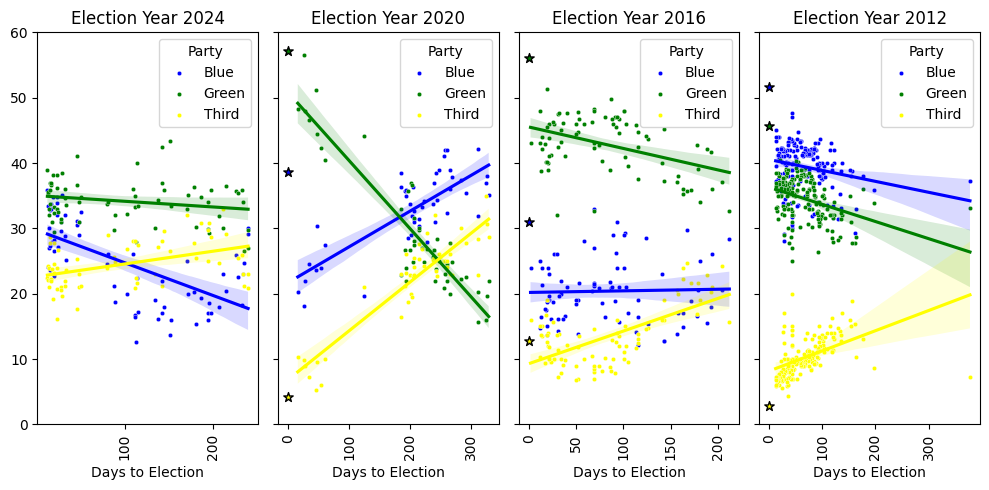

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

result_2020 = election_result_df[election_result_df['Election Year'] == 2020][['Result_Blue%', 'Result_Green%', 'Result_Third%']]
result_2016 = election_result_df[election_result_df['Election Year'] == 2016][['Result_Blue%', 'Result_Green%', 'Result_Third%']]
result_2012 = election_result_df[election_result_df['Election Year'] == 2012][['Result_Blue%', 'Result_Green%', 'Result_Third%']]


# List of unique election years
years = [2024, 2020, 2016, 2012]

# Create subplots with all years on the same row
fig, axes = plt.subplots(1, len(years), figsize=(10, 5), sharey=True)  # Use sharey=True for shared y-axis

# Define the common y-axis limits
y_min = 0
y_max = 60
# uniondata[['Blue', 'Green', 'Third', 'Candidate Total']].apply(pd.to_numeric, errors='coerce').max().max()

for i, year in enumerate(years):
    # Filter data for the current year
    subset = Three_way_data_2012to2024[Three_way_data_2012to2024['Election Year'] == year]
    
    # Create a copy of the DataFrame slice
    subset_copy = subset.copy()
    
    # Convert 'Blue', 'Green', and 'Third' columns to numeric, handling non-numeric values as NaN
    subset_copy[['Poll_Blue%', 'Poll_Green%', 'Poll_Third%']] = subset_copy[['Poll_Blue%', 'Poll_Green%', 'Poll_Third%']].apply(pd.to_numeric, errors='coerce')
    
    # Create a scatterplot for 'Blue', 'Green', and 'Third' on the same subplot
    sns.scatterplot(data=subset_copy, x='Days to Election', y='Poll_Blue%', color='blue', label='Blue', ax=axes[i],s=10)
    sns.scatterplot(data=subset_copy, x='Days to Election', y='Poll_Green%', color='green', label='Green', ax=axes[i],s=10)
    sns.scatterplot(data=subset_copy, x='Days to Election', y='Poll_Third%', color='yellow', label='Third', ax=axes[i],s=10)
    
    # Add trend lines using sns.regplot()
    sns.regplot(data=subset_copy, x='Days to Election', y='Poll_Blue%', scatter=False, ax=axes[i], color='blue')
    sns.regplot(data=subset_copy, x='Days to Election', y='Poll_Green%', scatter=False, ax=axes[i], color='green')
    sns.regplot(data=subset_copy, x='Days to Election', y='Poll_Third%', scatter=False, ax=axes[i], color='yellow')
    
    # Set y-axis limits for all subplots
    axes[i].set_ylim(y_min, y_max)
    
    # Remove y-axis label
    axes[i].set_ylabel('')
    
    # Set subplot title and legend
    axes[i].set_title(f'Election Year {year}')
    axes[i].legend(title='Party')
    
    # Rotate x-axis labels
    axes[i].tick_params(axis='x', rotation=90)

# Add result
x_result = 0

for i, year in enumerate(years):
     # Your existing code to create scatterplots and trend lines...

     # Add election result dots for each year except 2024
    if year == 2020:
        axes[i].scatter(x_result, result_2020['Result_Blue%'].values[0], color='blue', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2020['Result_Green%'].values[0], color='green', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2020['Result_Third%'].values[0], color='yellow', s=50, marker = "*", edgecolor='black')
    elif year == 2016:
        axes[i].scatter(x_result, result_2016['Result_Blue%'].values[0], color='blue', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2016['Result_Green%'].values[0], color='green', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2016['Result_Third%'].values[0], color='yellow', s=50, marker = "*", edgecolor='black')
    elif year == 2012:
        axes[i].scatter(x_result, result_2012['Result_Blue%'].values[0], color='blue', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2012['Result_Green%'].values[0], color='green', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2012['Result_Third%'].values[0], color='yellow', s=50, marker = "*", edgecolor='black')

    
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


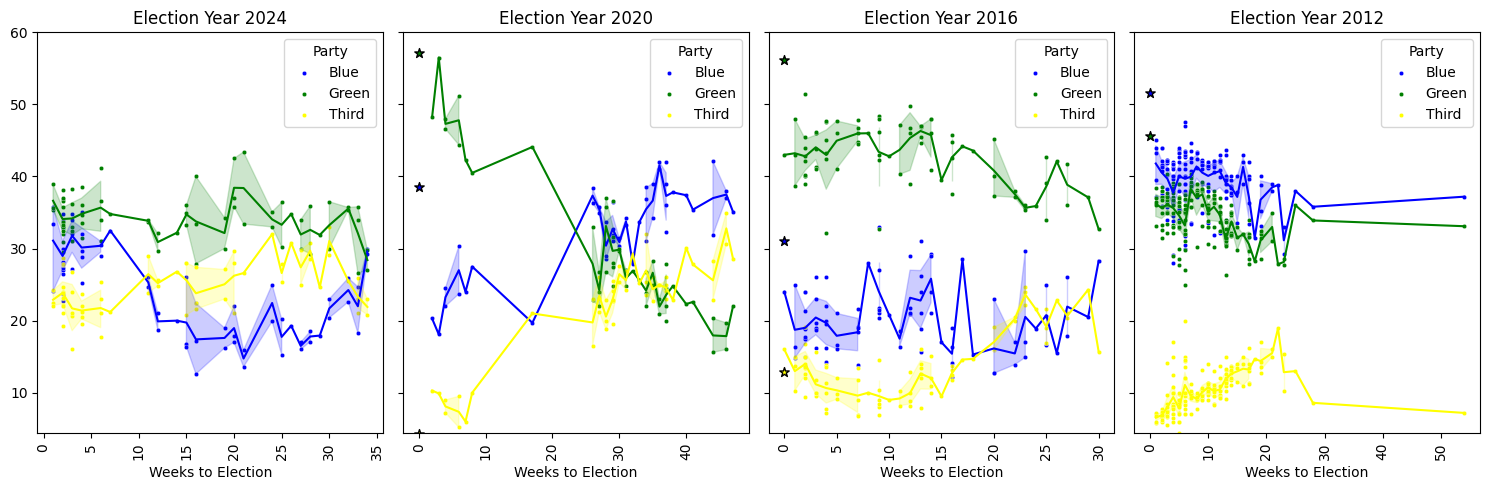

In [488]:
# Convert 'Days to Election' to 'Weeks to Election'
Three_way_data_2012to2024['Weeks to Election'] = (Three_way_data_2012to2024['Days to Election'] / 7).apply(np.floor)

# # Binning the data weekly within each election year
binned_data_weeks_to_election = Three_way_data_2012to2024.groupby(['Election Year', 'Weeks to Election'])[['Blue', 'Green', 'Third']].mean().reset_index()


import seaborn as sns
import matplotlib.pyplot as plt

result_2020 = election_result_df[election_result_df['Election Year'] == 2020][['Result_Blue%', 'Result_Green%', 'Result_Third%']]
result_2016 = election_result_df[election_result_df['Election Year'] == 2016][['Result_Blue%', 'Result_Green%', 'Result_Third%']]
result_2012 = election_result_df[election_result_df['Election Year'] == 2012][['Result_Blue%', 'Result_Green%', 'Result_Third%']]


# List of unique election years
years = [2024, 2020, 2016, 2012]

# Create subplots with all years on the same row
fig, axes = plt.subplots(1, len(years), figsize=(15, 5), sharey=True)  # Use sharey=True for shared y-axis

# Define the common y-axis limits
y_min = Three_way_data_2012to2024[['Blue', 'Green', 'Third', 'Candidate Total']].apply(pd.to_numeric, errors='coerce').min().min()
y_max = 60
# uniondata[['Blue', 'Green', 'Third', 'Candidate Total']].apply(pd.to_numeric, errors='coerce').max().max()

for i, year in enumerate(years):
    # Filter data for the current year
    subset = Three_way_data_2012to2024[Three_way_data_2012to2024['Election Year'] == year]
    
    # Create a copy of the DataFrame slice
    subset_copy = subset.copy()
    
    # Convert 'Blue', 'Green', and 'Third' columns to numeric, handling non-numeric values as NaN
    subset_copy[['Blue', 'Green', 'Third']] = subset_copy[['Blue', 'Green', 'Third']].apply(pd.to_numeric, errors='coerce')
    
    # Create a scatterplot for 'Blue', 'Green', and 'Third' on the same subplot
    sns.scatterplot(data=subset_copy, x='Weeks to Election', y='Blue', color='blue', label='Blue', ax=axes[i],s=10)
    sns.scatterplot(data=subset_copy, x='Weeks to Election', y='Green', color='green', label='Green', ax=axes[i],s=10)
    sns.scatterplot(data=subset_copy, x='Weeks to Election', y='Third', color='yellow', label='Third', ax=axes[i],s=10)
    
    # Add trend lines using sns.regplot()
#     sns.regplot(data=subset_copy, x='Weeks to Election', y='Blue', scatter=False, ax=axes[i], color='blue')
#     sns.regplot(data=subset_copy, x='Weeks to Election', y='Green', scatter=False, ax=axes[i], color='green')
#     sns.regplot(data=subset_copy, x='Weeks to Election', y='Third', scatter=False, ax=axes[i], color='yellow')
    
    # Connect Dots
    sns.lineplot(data=subset_copy, x='Weeks to Election', y='Blue', color='blue', ax=axes[i], legend=False)
    sns.lineplot(data=subset_copy, x='Weeks to Election', y='Green', color='green', ax=axes[i], legend=False)
    sns.lineplot(data=subset_copy, x='Weeks to Election', y='Third', color='yellow', ax=axes[i], legend=False)

    
    # Set y-axis limits for all subplots
    axes[i].set_ylim(y_min, y_max)
    
    # Remove y-axis label
    axes[i].set_ylabel('')
    
    # Set subplot title and legend
    axes[i].set_title(f'Election Year {year}')
    axes[i].legend(title='Party')
    
    # Rotate x-axis labels
    axes[i].tick_params(axis='x', rotation=90)

# Add result
x_result = 0

for i, year in enumerate(years):
    # Your existing code to create scatterplots and trend lines...

    # Add election result dots for each year except 2024
    if year == 2020:
        axes[i].scatter(x_result, result_2020['Result_Blue%'].values[0], color='blue', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2020['Result_Green%'].values[0], color='green', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2020['Result_Third%'].values[0], color='yellow', s=50, marker = "*", edgecolor='black')
    elif year == 2016:
        axes[i].scatter(x_result, result_2016['Result_Blue%'].values[0], color='blue', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2016['Result_Green%'].values[0], color='green', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2016['Result_Third%'].values[0], color='yellow', s=50, marker = "*", edgecolor='black')
    elif year == 2012:
        axes[i].scatter(x_result, result_2012['Result_Blue%'].values[0], color='blue', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2012['Result_Green%'].values[0], color='green', s=50, marker = "*", edgecolor='black')
        axes[i].scatter(x_result, result_2012['Result_Third%'].values[0], color='yellow', s=50, marker = "*", edgecolor='black')

    
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

